In [1]:
import orbipy as op
import numpy as np
import pandas as pd
from numba.core.ir import Raise
from numba.np.arrayobj import np_array
from orbipy import plotter

In [ ]:
class zero_correction(op.corrections.base_correction):
    def __init__(self, model, direction):
        super(zero_correction, self).__init__(model, direction)
        
    def calc_dv(self, t, s):
        return np.zeros_like(s)

In [ ]:
from scipy.optimize import bisect
from orbipy import event_detector


class border_correction_adjusted(op.corrections.border_correction):
    error_dv_exceeds_max = "Delta V > Max Delta V"
    
    def __init__(self, model, direction,
                 left, right, before=[],
                 iterations=(20,100), maxt=10*np.pi,
                 dv0 = 1e-12,
                 tol=1e-16, maxdv=1e-11,):
        super(border_correction_adjusted, self).__init__(model, direction,
                 left, right, before=[],
                 iterations=(20,100), maxt=10*np.pi,
                 dv0 = 1e-12,
                 tol=1e-16)
        self.sign = 0
        self.maxdv = maxdv
        
    def get_sign(self):
        return self.sign
        
    def calc_dv(self, t, s):
        self.sign = 0
        detector = event_detector(self.model, self.left+self.right, tol=self.tol)
        
        start_state = s.copy()
        start_velocity = s[3:6].copy()
        dv = self.dv0
        dr = self.direction(t, s)

        def get_border(velocity):
            start_state[3:6] = start_velocity + velocity * dr                
            _, ev = detector.prop(start_state, t, t + self.maxt, ret_df=False)
            
            if ev.shape[0] < 1:
                raise RuntimeError(self.error_borders_unreachable)
            
            return -1 if ev[-1,0] < len(self.left) else 1

        # root separation
        for i in range(self.iterations[0]):  
            sign_negative_dv = get_border(-dv)
            sign_positive_dv = get_border(dv)
            if sign_negative_dv == sign_positive_dv:
                dv *= 10
            else:
                break

        if i == self.iterations[0]:
            self.sign = get_border(dv)
            raise RuntimeError(self.error_root_separation)
        
        dvnorm = np.linalg.norm(dv) > self.maxdv
        if (dvnorm): # check delta-v by threshold
            self.sign = get_border(dv)
            raise RuntimeError(self.error_dv_exceeds_max)
        
        # root calculation
        res = bisect(get_border, -dv, dv, 
                     xtol=self.tol, maxiter=self.iterations[1],
                     full_output=True)
        
        target_velocity = res[0]
        r = np.zeros_like(self.model.get_zero_state())
        r[3:6] = target_velocity * dr
        return r
        

In [ ]:
model = op.crtbp3_model('Earth-Moon (default)', integrator=op.dopri5_integrator(), stm=True)
one_thousand_kms = (1-model.L1)/58

dr = one_thousand_kms / 2
zero_state = model.get_zero_state()
zero_state[0] = model.L1
alpha = 100

left = op.eventX(model.L1 - 3 * one_thousand_kms)
right = op.eventX(model.L1 + 3 * one_thousand_kms)
previous_alpha = [0, -2]
current_alpha = [0, -2]

def check_alpha(model, zero_state, alpha):
    direction = zero_state.copy()
    direction[0] += dr * np.cos(np.radians(alpha))
    direction[2] += dr * np.sin(np.radians(alpha))
    
    first_correction = zero_correction(model, op.y_direction())
    correction = border_correction_adjusted(model, op.unstable_direction(model), left, right)
    impulse_correction_method = op.strict_station_keeping(model, correction, correction, 0.1*np.pi)
    
    try:
        df = impulse_correction_method.prop(0.0, direction, N=25)
        return [alpha, 0]
    except RuntimeError as e:
        if str(e) == border_correction_adjusted.error_dv_exceeds_max or str(e) == border_correction_adjusted.error_root_separation:
            print(e)
            return [alpha, correction.get_sign()]
        print(e)
        raise e
   
while alpha <= 365:
    previous_alpha = current_alpha.copy()
    current_alpha = check_alpha(model, zero_state, alpha)
    print(previous_alpha, current_alpha)
    
    if previous_alpha[1] == -2:
        alpha += 365*2 / 100
        continue
        
    if previous_alpha[1] != current_alpha[1]:
        alpha = (previous_alpha[1] + current_alpha[1]) / 2
        continue
        
    alpha += 365*2 / 100
    print(alpha)



In [30]:
# =========================================================================

In [4]:
from scipy.optimize import bisect
from orbipy import event_detector


class border_correction_alpha(op.corrections.border_correction):    
    def __init__(self, model, direction,
                 left, right, before=[],
                 iterations=(20,100), maxt=10*np.pi,
                 dv0 = 1e-12,
                 tol=1e-16, maxdv=1e-11,):
        super(border_correction_alpha, self).__init__(model, direction,
                 left, right, before=[],
                 iterations=(20,100), maxt=5*np.pi,
                 dv0 = 1e-12,
                 tol=1e-16)
        self.dalpha = 15
        
    def calc_alpha(self, t, s, dr):
        detector = event_detector(self.model, self.left+self.right, tol=self.tol)
        
        start_state = s.copy()
        start_coordinates = s[0:3].copy()

        def get_border(alpha):
            state = model.get_zero_state().copy()
            x = start_coordinates[0] + np.cos(np.radians(alpha))*dr
            z = start_coordinates[2] + np.sin(np.radians(alpha))*dr
            state[[0, 2]] = x, z             
            
            df, ev = detector.prop(state, t, t + self.maxt, ret_df=False)
            
            if ev.shape[0] < 1:
                raise RuntimeError("Border unreachable")
            return -1 if ev[-1,0] < len(self.left) else 1

        # root separation
        alpha = 0
        while alpha < 360:
            sign_previous = get_border(alpha)
            sign_current = get_border(alpha + self.dalpha)
            
            if sign_previous == sign_current:
                alpha += self.dalpha
            else:
                break
                
        if alpha >= 360:
            raise RuntimeError(self.error_root_separation)
        
        # root calculation
        res = bisect(get_border, alpha, alpha + self.dalpha, 
                     xtol=self.tol, maxiter=self.iterations[1],
                     full_output=True)
        
        target_alpha = res[0]
        print(target_alpha)
        r = np.zeros_like(s)
        x = np.cos(np.radians(target_alpha))*dr
        z = np.sin(np.radians(target_alpha))*dr
        r[[0, 2]] = x, z
        return r
        

In [5]:
from matplotlib import pyplot as plt

model = op.crtbp3_model('Earth-Moon (default)', integrator=op.dopri5_integrator(), stm=True)
one_thousand_kms = (1-model.L1) / 61
left = op.eventX(model.L1 - 3 * one_thousand_kms)
right = op.eventX(model.L1 + 12 * one_thousand_kms)

dr = one_thousand_kms * 2
points = []

initial_state = model.get_zero_state()
initial_state[0] = model.L1
points.append(initial_state[[0, 2]])

for i in range(30):
    # if i % 25 == 0:
        # dr = dr / 2
    correction = border_correction_alpha(model, op.y_direction(), left, right)
    zero_velocity_point_correction = correction.calc_alpha(0, initial_state, dr)
    # print(np.linalg.norm(zero_velocity_point_correction))
    initial_state += zero_velocity_point_correction
    points.append(initial_state[[0, 2]])

zero_velocity_line = np.array(points)
print(zero_velocity_line)



89.43361495331983


capi_return is NULL
Call-back cb_solout_in___user__routines failed.


KeyboardInterrupt: 

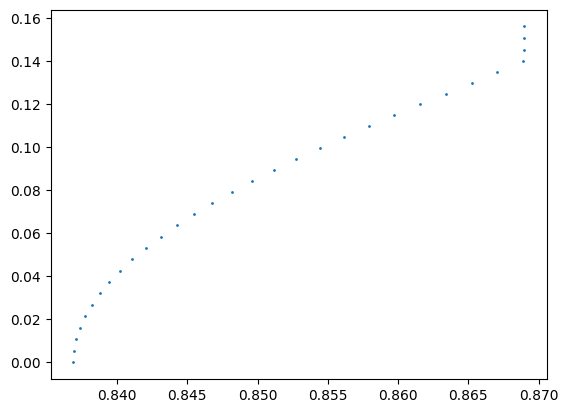

In [52]:
plt.scatter(zero_velocity_line[:,0], zero_velocity_line[:,1], s=1)
ax = plt.gca()
# ax.set_aspect('equal', adjustable='box')
plt.show()

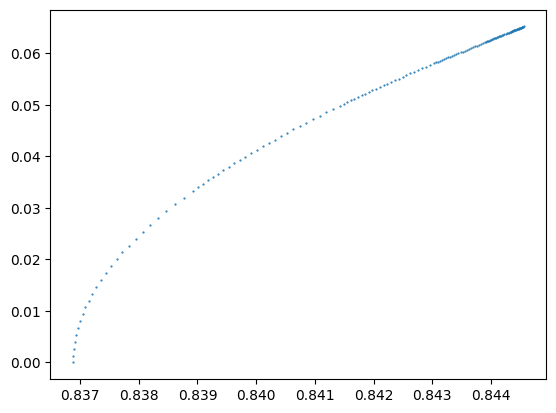

In [38]:
plt.scatter(zero_velocity_line[:,0], zero_velocity_line[:,1], s=0.3)
ax = plt.gca()
# ax.set_aspect('equal', adjustable='box')
plt.show()

In [14]:
correction = op.border_correction(model, op.unstable_direction(model), left, right)
first_correction = op.border_correction(model, op.y_direction(), left, right)
impulse_correction = op.simple_station_keeping(model, correction, correction, 2*np.pi)
zs = model.get_zero_state()
zs[[0, 2]] = zero_velocity_line[20]
df = impulse_correction.prop(0, zs, 10)



Simple station-keeping: 0 1 2 3 4 5 6 7 8 9 


AttributeError: 'plotter' object has no attribute 'get_df'

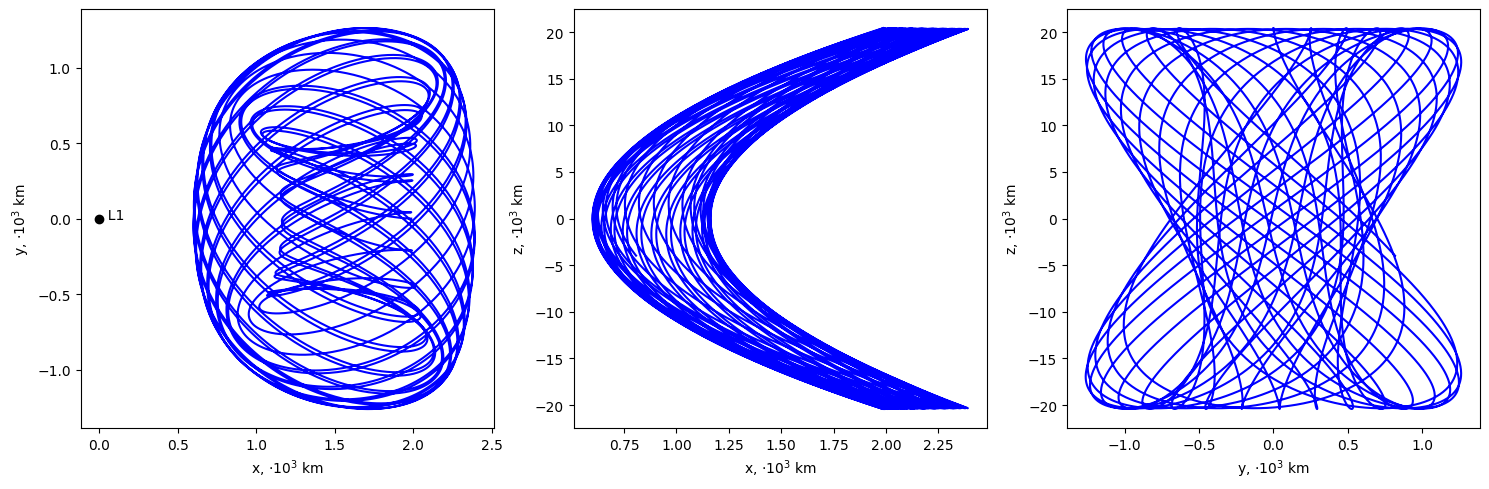

In [15]:
plotter = op.plotter.from_model(model, length_units='Mm', velocity_units='km/s')
ax = plotter.plot_proj(df, centers={'x':model.L1})
plotter.plot_proj(ax=ax, centers={'x':model.L1}, plottables=[plotter.L1, plotter], colors='k',ls='',marker='o')